In [27]:
import pandas as pd
import json

from sklearn.model_selection import train_test_split
from sklearn import cluster
from sklearn import preprocessing
from sklearn import tree
from sklearn import metrics

import seaborn
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

In [2]:
creatures_df = pd.read_json("creatures_data_v2.json")

creatures_df.tail(2)

,name,hit_points,can_be_summoned,can_be_convinced,see_invisible,can_be_paralysed,exp_points,weak_vs_earth,strong_vs_earth,immune_to_earth,...,immune_to_holy,weak_vs_agony,strong_vs_agony,immune_to_agony,weak_vs_fire,strong_vs_fire,immune_to_fire,weak_vs_ice,strong_vs_ice,immune_to_ice
616,Young Sea Serpents,1050,0,0,1,0,1000,0,0,1,...,0,0,0,0,0,1,0,0,0,1
617,Zombies,500,0,0,0,0,280,0,0,1,...,0,0,0,0,0,1,0,0,0,1


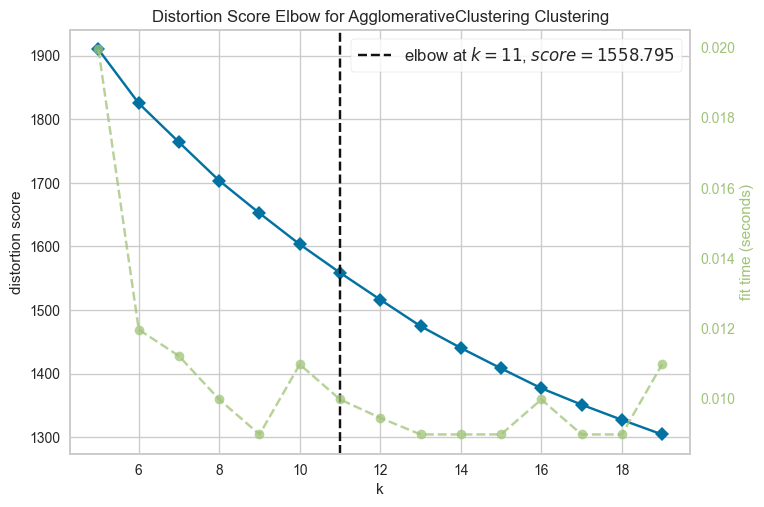

<Axes: title={'center': 'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [3]:
# Remove names
features = creatures_df[creatures_df.columns [1:]].columns

# Feature normalizer
minmax = preprocessing.MinMaxScaler()
minmax.fit(creatures_df[features])
creatures_df_model = pd.DataFrame(minmax.transform(creatures_df[features]),
                                    columns = features)

# Creates the model
model = cluster.AgglomerativeClustering()

# Gets the ideal number of clusters
visualizer = KElbowVisualizer(model, k = (5,20))
visualizer.fit(creatures_df_model)
visualizer.show()

In [4]:
# Now we can use the ideal number of clusters
model_ideal = cluster.AgglomerativeClustering(n_clusters=11)
model_ideal.fit(creatures_df_model[features])
creatures_df_model["cluster_id"] = model_ideal.labels_
creatures_df["cluster_id"] = model_ideal.labels_

In [5]:
creatures_df.groupby("cluster_id").mean()[["exp_points","hit_points"]]

,exp_points,hit_points
cluster_id,,
0,244.913462,383.548077
1,5431.151515,7248.030303
2,4887.405660,6517.688679
3,365.408163,544.367347
4,1243.703704,1440.740741
5,2097.552632,2975.526316
6,3785.660000,5139.900000
7,2403.581395,3256.046512
8,6167.224490,8581.224490


In [6]:
seaborn.set(rc={'figure.figsize':(12,4)})

<Axes: ylabel='cluster_id'>

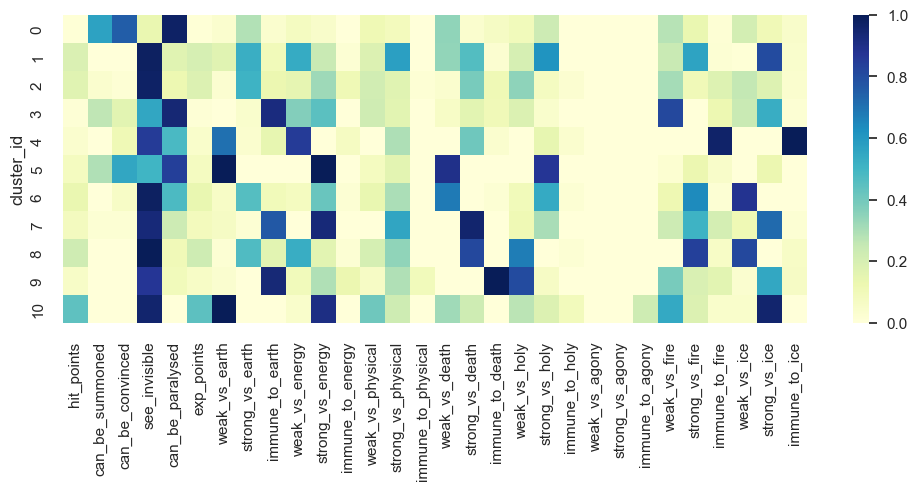

In [7]:
seaborn.heatmap(creatures_df_model.groupby("cluster_id").mean(),cmap="YlGnBu")

Training a Decision Tree to predict clusters

In [68]:
features = creatures_df_model.columns[:-1]
target = "cluster_id"
X_train, X_test, y_train, y_test = train_test_split(creatures_df_model[features], 
                                                    creatures_df_model[target], 
                                                    test_size=0.2, 
                                                    random_state=42)
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

clf_overfit = tree.DecisionTreeClassifier()
clf_overfit = clf_overfit.fit(creatures_df_model[features], creatures_df_model[target])

In [69]:
pd.Series(clf_overfit.feature_importances_, index = X_train.columns).sort_values(ascending=False)

immune_to_earth       0.104389
see_invisible         0.093263
weak_vs_earth         0.082690
hit_points            0.065357
strong_vs_ice         0.060034
strong_vs_death       0.054713
strong_vs_fire        0.053699
strong_vs_holy        0.049192
weak_vs_energy        0.047041
strong_vs_energy      0.046135
immune_to_death       0.045098
can_be_paralysed      0.044255
exp_points            0.039186
immune_to_ice         0.032377
weak_vs_fire          0.030825
weak_vs_ice           0.030772
weak_vs_death         0.025417
strong_vs_earth       0.024157
strong_vs_physical    0.023901
weak_vs_physical      0.011146
weak_vs_holy          0.010296
can_be_convinced      0.010199
immune_to_energy      0.009843
immune_to_fire        0.006016
immune_to_physical    0.000000
can_be_summoned       0.000000
immune_to_holy        0.000000
weak_vs_agony         0.000000
strong_vs_agony       0.000000
immune_to_agony       0.000000
dtype: float64

In [63]:
y_train_pred = clf.predict(X_train)
y_train_prob = clf.predict_proba(X_train)
y_test_pred = clf.predict(X_test)
y_test_prob = clf.predict_proba(X_test) 

print("Train accuracy: {}".format(metrics.accuracy_score(y_train,y_train_pred)))
print("Train AUC: {}".format(metrics.roc_auc_score(y_train,y_train_prob, multi_class = "ovr")))

print("Test accuracy: {}".format(metrics.accuracy_score(y_test,y_test_pred)))
print("Test AUC: {}".format(metrics.roc_auc_score(y_test,y_test_prob, multi_class = "ovr")))

Train accuracy: 1.0
Train AUC: 1.0
Test accuracy: 0.782258064516129
Test AUC: 0.8486427645023649
